This notebook implements TANE algorithm to find exact FDs in the dataset. The implemention relies on lecture slides and the orginal TANE paper to come up with the algorithm. I tested it on several examples and compared our output with the metanome. Below you will find the implementation and the example on which I tested the algorithm.

In [73]:
import pandas as pd
from IPython.display import Image

#### Implementation

In [165]:

## Global PLIs
dict_plis = {}


def pli_intersect(p1, p2):
    """Computes the intersection of 2 position list indices p1 and p2"""
    pli, prob = {}, {}
    for c, s in enumerate(p1):
        for row in s:
            prob[row] = c
    for c, s in enumerate(p2):
        for row in s:
            if row in prob:
                key = (c, prob[row])
                if key in pli:
                    pli[key].add(row)
                else:
                    pli[key] = { row }
    return list(v for v in pli.values() if len(v) > 1)


def pli_single(a, D):
    """Computes the position list index of a column "a" in the database table D"""
    pli = {}
    for row in range(D.shape[0]):
        key = D.at[row, a]
        if key in pli:
            pli[key].add(row)
        else:
            pli[key] = { row }

    return list(v for v in pli.values() if len(v) > 1)


def sort_single(s):
    """Orders the LHS in standard prefix code"""
    return ''.join(sorted(list(s)))

def sort(F):
    """Sorts all the LHS into standard prefix code form"""
    return sorted(sort_single(s) for s in F)
    

def find_pli(E, F, f):
    """Looks for PLIs for LHS f in Potential and validated LHS sides"""

    for i in F:
        if i[0] == f:
            return i[1]
    for i in E:
        if i[0] == f:
            return i[1]


def key_error(pl1):
    """Computes the error associated with the plis"""
    c = 0
    for k in pl1:  
        c += len(k)
    return c - len(pl1)

def find_index(F, x):
    """Find the index of the location of the X in the LHS F list"""
    c = 0
    for i in F:
        if i[0] == x:
            return c
        c += 1

def set_intersect(X, C):
    """Finding the candidate sets of X that can be potential minimal FDs"""

    ## Adding the RHS candidates from previous layers
    intersection = C[sort_single(X.replace(X[0], ""))]
    for B in X:
        intersection = intersection & C[sort_single(X.replace(B,""))]

    return intersection


def candidates(F):
    """Generate the left hand side of the FDs level by level in prefix code form"""
    LHS = [i[0] for i in F] 
    Fs, E = sort(LHS), []
    for i1 in range(len(Fs)):
        for i2 in range(i1+1, len(Fs)):
            if Fs[i1][:-1] == Fs[i2][:-1] and Fs[i1][-1] < Fs[i2][-1]:
                f = sort_single(set(fs for fs in Fs[i1]).union({Fs[i2][-1]}))
                superset = 0
                for i in f:
                    if f.replace(i, "") in LHS:
                        superset += 1
                if superset == len(f):
                    ## Saving the plis in the candidate 
                    E.append((f, pli_intersect(find_pli(F, F, Fs[i1]), find_pli(F, F, Fs[i2]))))     

                    ## Saving the result in the global     
                    dict_plis[f] = pli_intersect(find_pli(F, F, Fs[i1]), find_pli(F, F, Fs[i2]))

                    
    return E


def prune(E,C):
    """Pruning the LHS of the FDs based on the key pruning and candidate sets rules."""

    #print("Prunning part....")
    
    ## Initializing the LHS
    F = E.copy()

    #print("F start: ", F)
    ## traverse the LHS and prune LHS which has has empty RHS candidate sets  or where LHS is a super key or key
    for X,p in E:

        ## If the C(X) is empty there are no candidate RHS to explore for all the LHS that are supserset of X
        if len(C[X]) == 0:
            ## Removing the LHS from the prefix tree, because all the FDs found from it would be non-minimal

            #print("Removing ", X ," from, ", F)       
            i = find_index(F, X)
            F.pop(i)

            if len(F) == 0:
                return F

        #print("Checking Plis")
        #print("C: ", C)
        #print("F: ", F)
        #print("X: ", X)
        ## Checking whether it is a Superkey(key)
        
        pli = dict_plis[X]
        error = key_error(pli)
        
        is_key = error == 0
        if is_key:
            for A in (C[X] - set(X)):
    
                ## Printing Non minimal FDs from keys
                XUA_B = sort_single((set(X).union(set(A))).difference(set(X[0])))

                if XUA_B in C:
                    intersection = C[XUA_B]
                else:
                    intersection = set()

                """
                for B in X:
                    XUA_B = sort_single((set(X).union(set(A))).difference(set(B)))
                    if XUA_B in C:
                        a = C[XUA_B]
                    else:
                        a = set()
                    intersection = intersection & a

                """
                if A in intersection:
                    print(f"**** FD: {X} to {A}")

            #print("F: ", F)
            #print("Removing superkey(X): ", X)
            ## Removing the LHS from the prefix tree, because all the FDs found from superset of the keys would be non-minimal
            i = find_index(F, X)
            F.pop(i)


    #print("F end: ", F)

    #print("Done Prunning part....")
    return F

def dependencies(E, F, C):
    """Checks for the FD dependencies and produces the new potential candidate sets of RHS"""
    C_plus = {}
    #print("Dependency checking....")
    #print("E: ", E)
    ## Add candidate sets for the new level from the previous levels
    for X,p in E:
        C_plus[X] = set_intersect(X, C)

    #print("Candidates set: ", C_plus)


    for X,p in E:
        #print("Candidates of ", X)
        #print("C_plus before FD checking: ", C_plus[X])
        ## Minimality rules
        for A in X:
            candidates = C_plus[X]
            #print("Candidates of ", X, "are ", candidates)

            ## Checking the potential RHS of X
            if A in candidates:
                #print("Checking FDs: ", sort_single(set(X).difference(set(A))), "-->", A)
                ## Checking for  X\A --> A
                pli_LHS = find_pli(E, F, sort_single(set(X).difference(set(A))))
                pli_RHS = find_pli(E, F, X)              
                error_LHS = key_error(pli_LHS)
                error_RHS = key_error(pli_RHS)

                #print("Checking FD ", sort_single(set(X).difference(set(A))), " to ", A)
                #print(pli_LHS, pli_RHS)         
        
                if error_LHS == error_RHS:
                    print("**** FD: ", X.replace(A,"") ,"to", A)

                    ## Remove A from candidate sets as FD is found from X\A --> A                  
                    C_plus[X] = C_plus[X] - set(A)

                    #print("Candidates of ", X, " after FD found")
                    #print(C_plus[X])

                    
                    for b in sort_single(set(R).difference(set(X))):
                        C_plus[X] = C_plus[X] - set(b)
                    
                    #print("Candidates of ", X, " after FD found")
                    #print(C_plus[X])

        #print("C_plus After FD checking: ", C_plus[X])


    return C_plus


def apriori(R, r):
    """Main function to discover all non trivial minimal FDs using TANE algorithm"""
    
    # Initial column combination of size of 1
    k = 1 
    # Starting with single attributes and their singleton PLIs
    E = []
    for a in R:

        dict_plis[a] = pli_single(a, r)
        E.append((a, pli_single(a, r)))


    # Candidates for each of single LHS for single attributes
    C = {}
    for a in R: 
        C[a] = R 
    #print("Candidates for: ")
    #print(C)

    ## Determine the non-unique LHS
    F = prune(E,C)

    #print("Potential F to check")
    #print(F)

    ## While there are non-dependent LHS that have not been pruned or have candidate RHS
    while len(F) > 0:
        print(f"FDs between level {k} and level ", k + 1)
        #print("Printing new candidates ")
        E = candidates(F)
        #print(E)
        #print("Printing new candidates after dependency checking")
        C = dependencies(E, F, C)
        #print(C)

        #print("Printing Pruned LHS")
        F = prune(E,C)
        #print(F)
        k = k + 1 
        print("")

#### Motivation

One of the applications of FD is that it allows to remove redundancy in the tables, as the figure below show. In addition, it allows to perform higher order normalization that keep data efficiently stored and less prone to quality issues

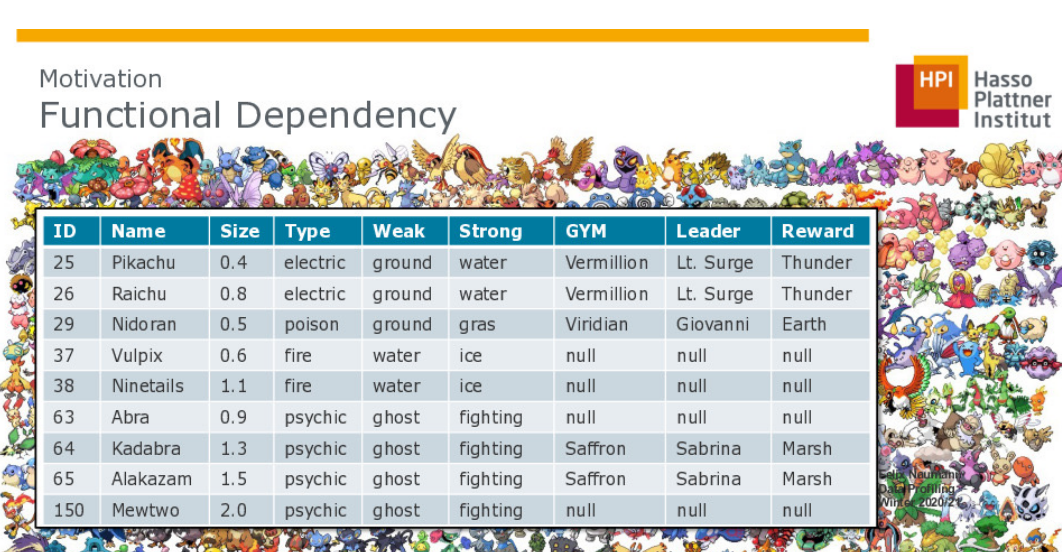

In [166]:
Image(filename='./metanome/why1.png')

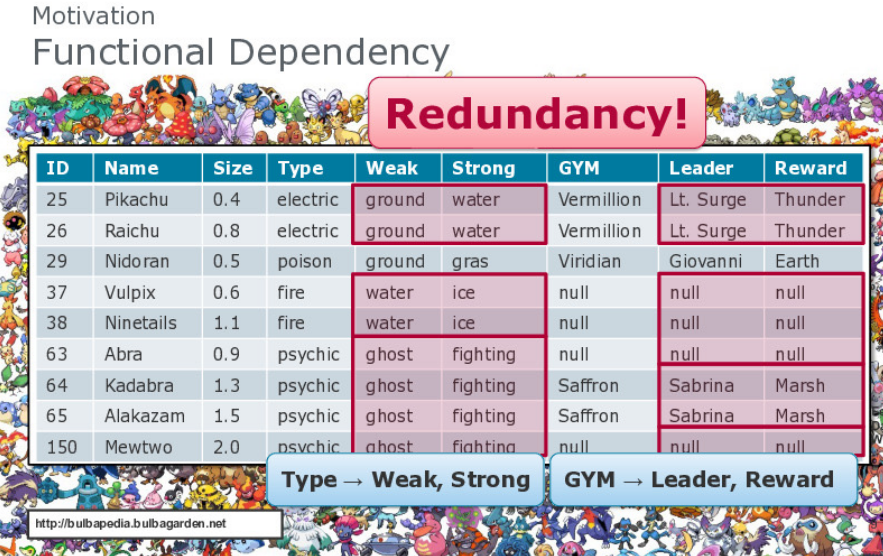

In [167]:
Image(filename='./metanome/why2.png')

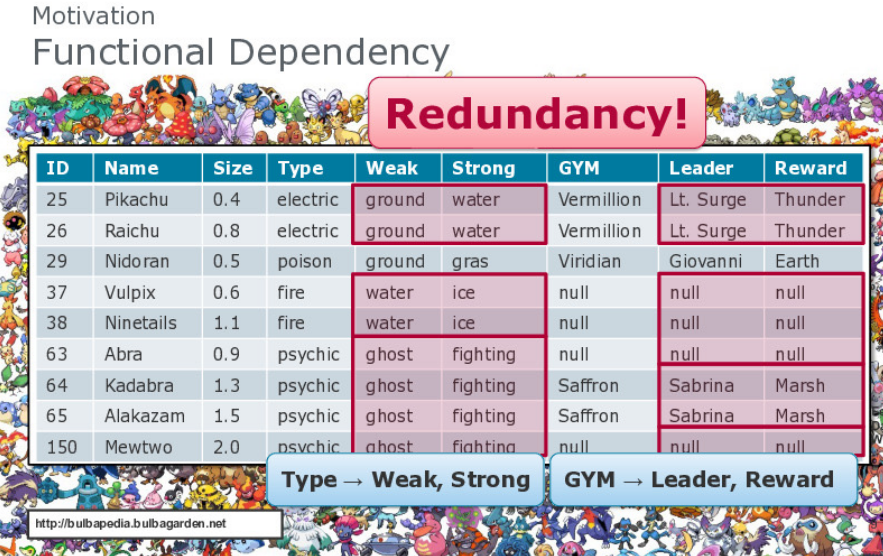

In [168]:
Image(filename='./metanome/why2.png')

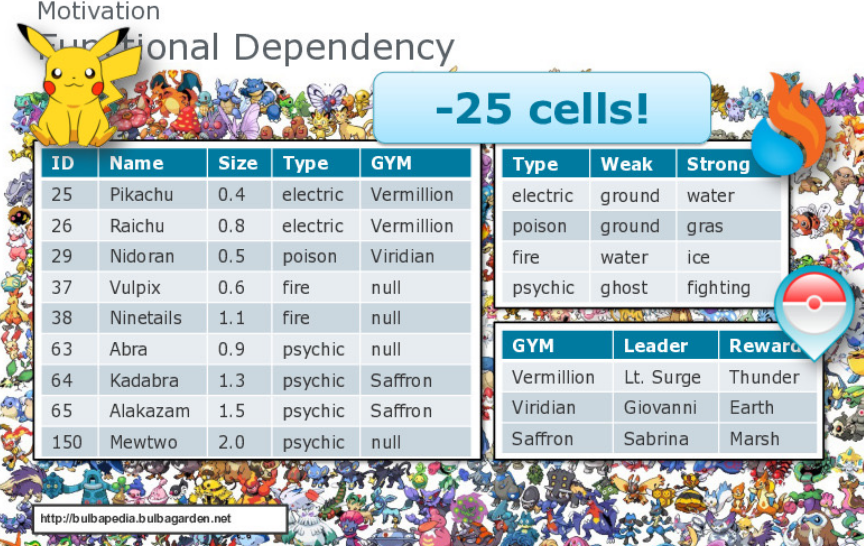

In [169]:
Image(filename='./metanome/why3.png')

#### Why Naive approach is infeasible

Exponential search space, not to mention the verification of FDs, and cannot work for large number of columns

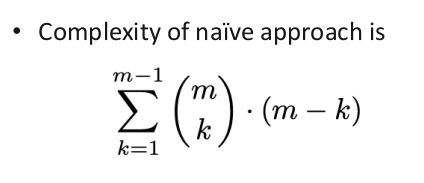

In [170]:
Image(filename='./metanome/naive.png')

Hence, need to efficient algorithm that can be used to search nonmimal and non-trivial FDs

#### Definition

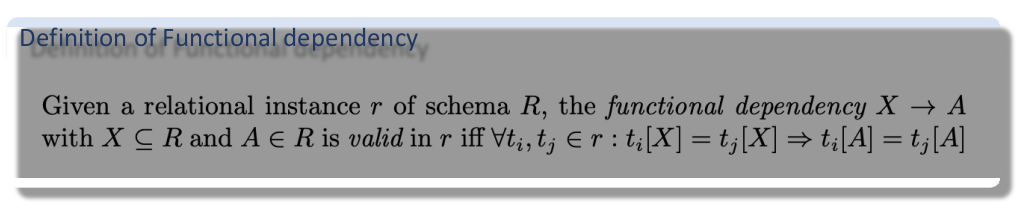

In [171]:
Image(filename='./metanome/def1.png')

But we can make it easy by focusing on single attribute right hand side (RHS)

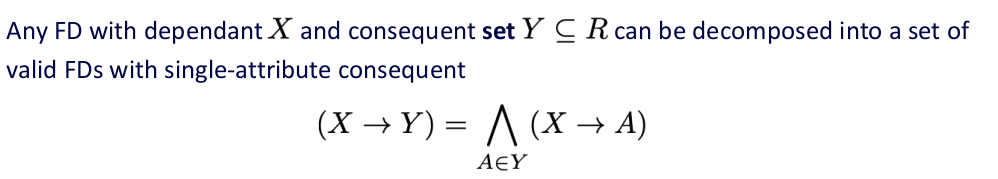

In [172]:
Image(filename='./metanome/def2.png')

Also we can focus only those attributes that are not present in the dependent(LHS) of the FDs

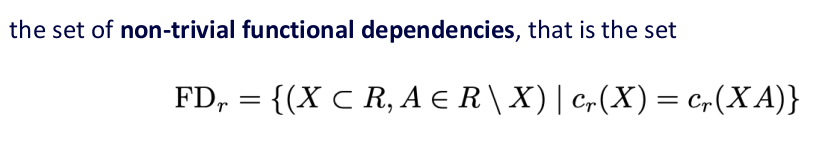

In [173]:
Image(filename='./metanome/def3.png')

TANE finds minimal non-trivial single attribute (consequent) FDs using clever lattic traversal with prunning rules, making it efficient in discovering exact FDs

We implemented the algorithm and compared its output on below examples to measure its correctioness. We used the pseudocode implentation on the slides to implement the algorithm, also looking at parts from the paper to understand few o fthe concepts in a better way. 

#### Testing

##### Example: 1

In [174]:
table = pd.read_csv("./dataset/trial-tane.csv")
table


,a,b,c,d,e
0,C,3,X,722,112
1,A,1,X,289,553
2,A,1,Y,125,583
3,B,1,X,289,513
4,C,1,X,289,553


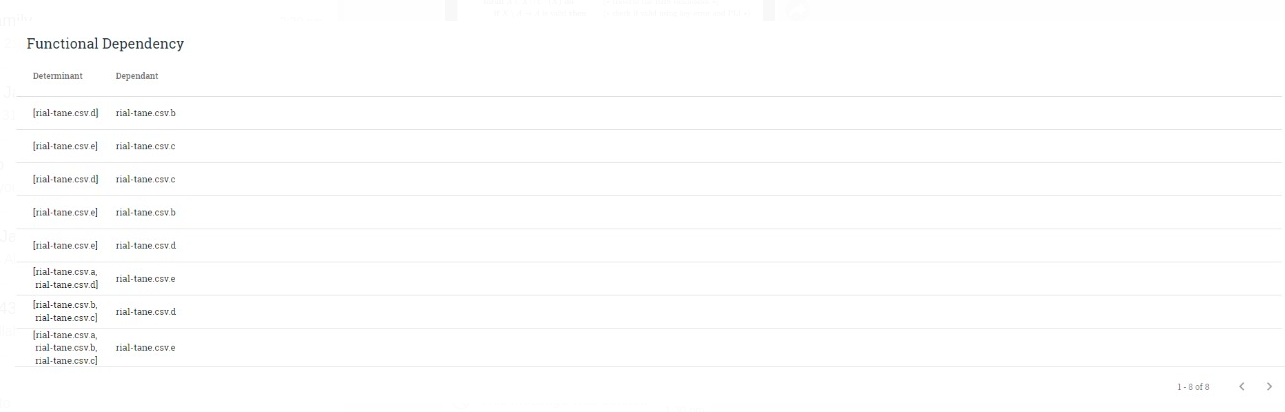

In [175]:
Image(filename='./metanome/tane_tutorial.png')


In [176]:
R  = set(table.columns)
D = table
apriori(R, D)

FDs between level 1 and level  2
**** FD:  d to b
**** FD:  e to b
**** FD:  d to c
**** FD:  e to c
**** FD:  e to d
**** FD: ad to e

FDs between level 2 and level  3
**** FD:  bc to d
**** FD: abc to e

FDs between level 3 and level  4



##### Example 2

In [177]:
table = pd.read_csv("iris.csv", header = None)
table.columns = [str(i) for i in range(1, len(table.columns) + 1)]
table

,1,2,3,4,5
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


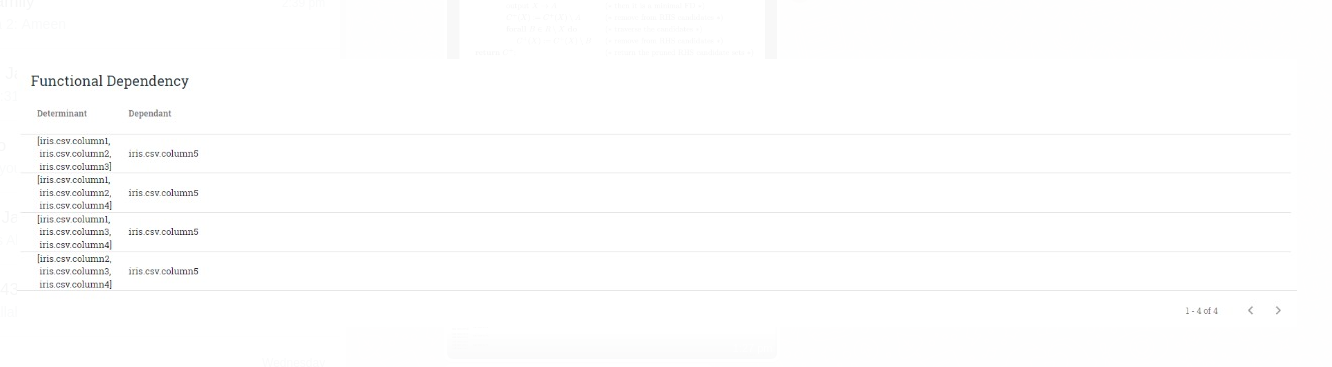

In [178]:
Image(filename='./metanome/iris.png')

In [179]:
R  = set(table.columns)
D = table
apriori(R, D)

FDs between level 1 and level  2

FDs between level 2 and level  3

FDs between level 3 and level  4
**** FD:  123 to 5
**** FD:  124 to 5
**** FD:  134 to 5
**** FD:  234 to 5

FDs between level 4 and level  5



##### Example 3

In [180]:
table = pd.read_csv("./dataset/chess.csv", header = None)
table.columns = [str(i) for i in range(1, len(table.columns) + 1)]
table


,1,2,3,4,5,6,7
0,a,1,b,3,c,2,draw
1,a,1,c,1,c,2,draw
2,a,1,c,1,d,1,draw
3,a,1,c,1,d,2,draw
4,a,1,c,2,c,1,draw
...,...,...,...,...,...,...,...
28051,b,1,g,7,e,5,sixteen
28052,b,1,g,7,e,6,sixteen
28053,b,1,g,7,e,7,sixteen
28054,b,1,g,7,f,5,sixteen


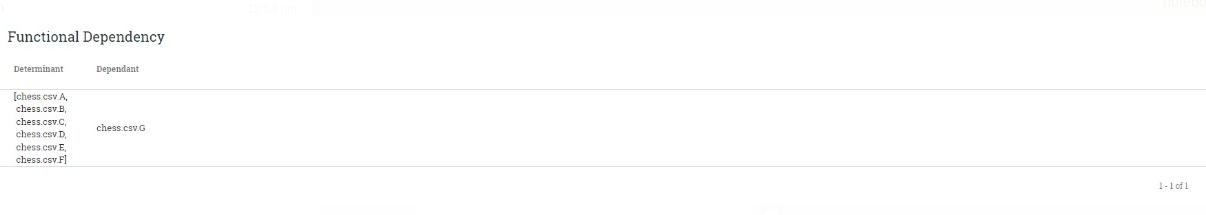

In [181]:
Image(filename='./metanome/chess.png')

In [182]:
R  = set(table.columns)
D = table
apriori(R, D)

FDs between level 1 and level  2

FDs between level 2 and level  3

FDs between level 3 and level  4

FDs between level 4 and level  5

FDs between level 5 and level  6
**** FD: 123456 to 7

FDs between level 6 and level  7



##### Example 4

In [183]:
table = pd.read_csv("./dataset/balance-scale.csv", header = None)
table.columns = [str(i) for i in range(1, len(table.columns) + 1)]
table


,1,2,3,4,5
0,B,1,1,1,1
1,R,1,1,1,2
2,R,1,1,1,3
3,R,1,1,1,4
4,R,1,1,1,5
...,...,...,...,...,...
620,L,5,5,5,1
621,L,5,5,5,2
622,L,5,5,5,3
623,L,5,5,5,4


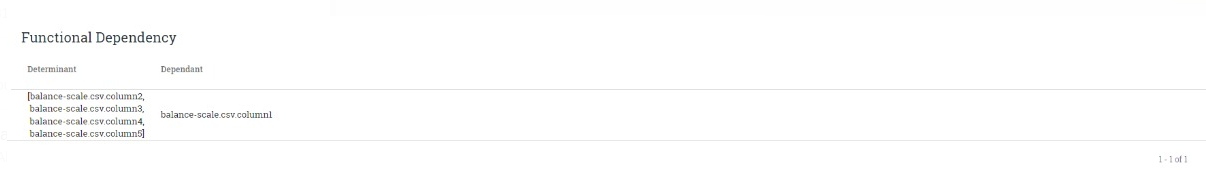

In [184]:
Image(filename='./metanome/balance.png')

In [186]:
R  = set(table.columns)
D = table
apriori(R, D)

FDs between level 1 and level  2

FDs between level 2 and level  3

FDs between level 3 and level  4
**** FD: 2345 to 1

FDs between level 4 and level  5



##### Example 5

In [187]:
table = pd.read_csv("./dataset/nursery.csv",header = None)
table.columns = [str(i) for i in range(1, len(table.columns) + 1)]
table

,1,2,3,4,5,6,7,8,9
0,usual,proper,complete,1,convenient,convenient,nonprob,recommended,recommend
1,usual,proper,complete,1,convenient,convenient,nonprob,priority,priority
2,usual,proper,complete,1,convenient,convenient,nonprob,not_recom,not_recom
3,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended,recommend
4,usual,proper,complete,1,convenient,convenient,slightly_prob,priority,priority
...,...,...,...,...,...,...,...,...,...
12955,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,priority,spec_prior
12956,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,not_recom,not_recom
12957,great_pret,very_crit,foster,more,critical,inconv,problematic,recommended,spec_prior
12958,great_pret,very_crit,foster,more,critical,inconv,problematic,priority,spec_prior


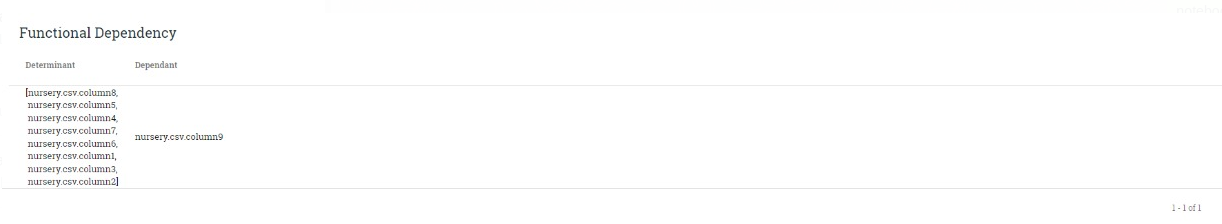

In [188]:
Image(filename='./metanome/nursery.png')

In [189]:
R  = set(table.columns)
D = table
apriori(R, D)

FDs between level 1 and level  2

FDs between level 2 and level  3

FDs between level 3 and level  4

FDs between level 4 and level  5

FDs between level 5 and level  6

FDs between level 6 and level  7

FDs between level 7 and level  8
**** FD: 12345678 to 9

FDs between level 8 and level  9

